# Getting started with MovingPanda

MovingPandas provides a trajectory datatype based on GeoPandas

https://github.com/anitagraser/movingpandas

In [1]:
import urllib
import os
import pandas as pd
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from datetime import datetime, timedelta
from trajectory import Trajectory 

## Creating a trajectory from scratch

Trajectory objects consist of a trajectory ID and a GeoPandas GeoDataFrame with a DatetimeIndex. The data frame therefore represents the trajectory data as a Pandas time series with associated point locations (and optional further attributes).

In [18]:
df = pd.DataFrame([
  {'geometry':Point(0,0), 't':datetime(2018,1,1,12,0,0)},
  {'geometry':Point(6,0), 't':datetime(2018,1,1,12,6,0)},
  {'geometry':Point(6,6), 't':datetime(2018,1,1,12,10,0)},
  {'geometry':Point(9,9), 't':datetime(2018,1,1,12,15,0)}
]).set_index('t')
geo_df = GeoDataFrame(df, crs={'init': '31256'})
traj = Trajectory(1, geo_df)

print(traj)

Trajectory 1 (2018-01-01 12:00:00 to 2018-01-01 12:15:00) | Size: 4 | Length: 16.2m
Bounds: (0.0, 0.0, 9.0, 9.0)
LINESTRING (0 0, 6 0, 6 6, 9 9)


The notebook environment automatically plots Shapely geometry objects like the LineString returned by to_linestring() or the Point returned by get_position_at():

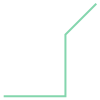

In [19]:
traj.to_linestring()

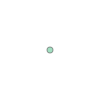

In [20]:
traj.get_position_at(datetime(2018,1,1,12,6,0), method="nearest")    

In [21]:
print(traj.get_position_at(datetime(2018,1,1,12,6,0), method="nearest"))

POINT (6 0)


## Extracting trajectory segments based on time or geometry (i.e. clipping)

First, let's extract the trajectory segment for a certain time period:

In [22]:
print(traj.get_segment_between(datetime(2018,1,1,12,6,0),datetime(2018,1,1,12,12,0)))

Trajectory 1 (2018-01-01 12:06:00 to 2018-01-01 12:10:00) | Size: 2 | Length: 6.0m
Bounds: (6.0, 0.0, 6.0, 6.0)
LINESTRING (6 0, 6 6)


(You can ignore any SettingWithCopyWarnings that may appear here)

Now, let's extract the trajectory segment that intersects with a given polygon:

In [23]:
xmin, xmax, ymin, ymax = 2, 8, -10, 5
polygon = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin)])

intersection = traj.clip(polygon)

print(intersection[0])

Trajectory 1_0 (2018-01-01 12:02:00 to 2018-01-01 12:09:20) | Size: 3 | Length: 9.0m
Bounds: (2.0, 0.0, 6.0, 5.0)
LINESTRING (2 0, 6 0, 6 5)


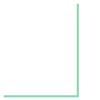

In [24]:
intersection[0].to_linestring()

## Loading trajectory data from GeoPackage

The MovingPandas repository contains a demo GeoPackage file that can be loaded as follows:

In [25]:
url = 'https://github.com/anitagraser/movingpandas/raw/master/demo/demodata_geolife.gpkg'
filename = url.split('/')[-1] 

response = urllib.request.urlopen(url)
content = response.read()
with open(filename, 'wb' ) as f:
    f.write( content )


--2019-06-17 16:46:37--  https://github.com/anitagraser/movingpandas/raw/master/demo/demodata_geolife.gpkg
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/anitagraser/movingpandas/master/demo/demodata_geolife.gpkg [following]
--2019-06-17 16:46:37--  https://raw.githubusercontent.com/anitagraser/movingpandas/master/demo/demodata_geolife.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 991232 (968K) [application/octet-stream]
Saving to: ‘demodata_geolife.gpkg.1’

demodata_geolife.gp 100%[===================>] 968.00K  --.-KB/s    in 0.06s   

2019-06-17 16:46:37 (14.6 MB/s) - ‘demodata_geolife

In [26]:
assert(os.path.exists(filename))

demo			 LICENSE.txt	   sandbox
demodata_geolife.gpkg	 overlay.py	   tests
demodata_geolife.gpkg.1  __pycache__	   trajectory_prediction_evaluator.py
geometry_utils.py	 README.md	   trajectory_predictor.py
getting_started.ipynb	 requirements.txt  trajectory.py
__init__.py		 runtime.txt	   trajectory_sampler.py


Now, we can use GeoPandas' read_file() function to read the GeoPackage and construct the Trajectories:

In [27]:
t_start = datetime.now()
df = read_file('demodata_geolife.gpkg')
df['t'] = pd.to_datetime(df['t'])
df = df.set_index('t')
print("Finished reading {} rows in {}".format(len(df),datetime.now() - t_start))

t_start = datetime.now()
trajectories = []
for key, values in df.groupby(['trajectory_id']):
    trajectory = Trajectory(key, values)
    print(trajectory)
    trajectories.append(trajectory)
print("Finished creating {} trajectories in {}".format(len(trajectories),datetime.now() - t_start))

Finished reading 5908 rows in 0:00:00.311005
Trajectory 1 (2008-12-11 04:42:14 to 2008-12-11 05:15:46) | Size: 466 | Length: 6210.1m
Bounds: (116.385602, 39.862378, 116.393553, 39.898723)
LINESTRING (116.391305 39.898573, 116.391317 39.898617, 116.390928 39.898613, 116.390833 39.898635, 
Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 897 | Length: 38728.7m
Bounds: (116.319212, 39.971703, 116.592616, 40.082514)
LINESTRING (116.590957 40.071961, 116.590905 40.072007, 116.590879 40.072027, 116.590915 40.072004, 
Trajectory 3 (2009-02-04 04:32:53 to 2009-02-04 11:20:12) | Size: 1810 | Length: 12739.2m
Bounds: (116.332706, 39.897023, 116.387307, 39.927949)
LINESTRING (116.385689 39.899773, 116.385654 39.899651, 116.385548 39.899699, 116.385527 39.899632, 
Trajectory 4 (2009-03-10 10:36:45 to 2009-03-10 12:01:07) | Size: 1864 | Length: 14357.6m
Bounds: (116.327347, 39.896671, 116.389611, 39.927947)
LINESTRING (116.388053 39.903418, 116.388042 39.9035, 116.388035 39.903467,

Let's look at one of those trajectories:

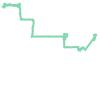

In [28]:
trajectories[3].to_linestring()

## Finding intersections with a Shapely polygon

In [29]:
xmin, xmax, ymin, ymax = 116.3685035,116.3702945,39.904675,39.907728
polygon = Polygon([(xmin,ymin), (xmin,ymax), (xmax,ymax), (xmax,ymin), (xmin,ymin)])

intersections = []
for key, values in df.groupby(['trajectory_id']):
    traj = Trajectory(key, values)
    for intersection in traj.clip(polygon):
        intersections.append(intersection)
print("Found {} intersections".format(len(intersections)))

Found 3 intersections


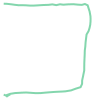

In [30]:
intersections[2].to_linestring()

## Splitting trajectories

Gaps are quite common in trajectories. For example, GPS tracks may contain gaps if moving objects enter tunnels where GPS reception is lost. In other use cases, moving objects may leave the observation area for longer time before returning and continuing their recorded track.

Depending on the use case, we therefore might want to split trajectories at observation gaps that exceed a certain minimum duration:

In [39]:
print(trajectories[1])

Trajectory 2 (2009-06-29 07:02:25 to 2009-06-29 11:13:12) | Size: 897 | Length: 38728.7m
Bounds: (116.319212, 39.971703, 116.592616, 40.082514)
LINESTRING (116.590957 40.071961, 116.590905 40.072007, 116.590879 40.072027, 116.590915 40.072004, 


In [40]:
split = trajectories[1].split_by_observation_gap(timedelta(minutes=5))
for traj in split:
    print(traj)

Trajectory 2_0 (2009-06-29 07:02:25 to 2009-06-29 07:17:05) | Size: 152 | Length: 2554.1m
Bounds: (116.586342, 40.07196, 116.592616, 40.082514)
LINESTRING (116.590957 40.071961, 116.590905 40.072007, 116.590879 40.072027, 116.590915 40.072004, 
Trajectory 2_1 (2009-06-29 07:29:35 to 2009-06-29 08:20:15) | Size: 619 | Length: 33733.3m
Bounds: (116.319212, 39.971703, 116.587085, 40.079854)
LINESTRING (116.587031 40.07951, 116.587041 40.079514, 116.587032 40.079524, 116.586998 40.079528, 1
Trajectory 2_2 (2009-06-29 10:57:17 to 2009-06-29 11:13:12) | Size: 126 | Length: 2326.4m
Bounds: (116.319598, 39.999772, 116.327485, 40.007696)
LINESTRING (116.319697 40.007513, 116.319706 40.007586, 116.319636 40.007687, 116.319598 40.007696, 


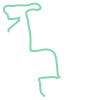

In [41]:
split[0].to_linestring()

## Generalizing trajectories

To reduce the size of trajectory objects, we can generalize them, for example, using the Douglas-Peucker algorithm:

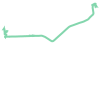

In [33]:
trajectories[1].to_linestring()

Try different tolerance settings and observe the results in line geometry and therefore also length:

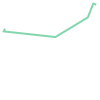

In [36]:
generalized_traj = trajectories[1].generalize(mode='douglas-peucker', tolerance=0.01)
generalized_traj.to_linestring()

In [37]:
print('Original length: %s'%(trajectories[1].get_length()))
print('Generalized length: %s'%(generalized_traj.get_length()))

Original length: 38728.7215399247
Generalized length: 29395.614300556055


In [38]:
generalized_traj.df

,id,sequence,trajectory_id,tracker,geometry,prev_pt,dist_to_prev,t,gap
t,,,,,,,,,
2009-06-29 07:02:25,1556,1090,2,0,POINT (116.590957 40.071961),NaN,0.000000,2009-06-29 07:02:25,0
2009-06-29 07:34:00,1762,1296,2,0,POINT (116.582176 40.074804),POINT (116.590957 40.071961),811.288792,2009-06-29 07:34:00,1
2009-06-29 07:38:20,1814,1348,2,0,POINT (116.56637 40.035079),POINT (116.582176 40.074804),4617.530081,2009-06-29 07:38:20,1
2009-06-29 07:46:15,1909,1443,2,0,POINT (116.472209 39.978068),POINT (116.56637 40.035079),10222.803028,2009-06-29 07:46:15,1
2009-06-29 08:13:40,2248,1782,2,0,POINT (116.322487 39.994491),POINT (116.472209 39.978068),12885.973209,2009-06-29 08:13:40,1
2009-06-29 11:03:32,2402,1936,2,0,POINT (116.324874 39.999788),POINT (116.322487 39.994491),623.109197,2009-06-29 11:03:32,2
2009-06-29 11:13:12,2452,1986,2,0,POINT (116.32746 40.000522),POINT (116.324874 39.999788),234.909994,2009-06-29 11:13:12,2
